In [1]:
import cv2, ast
import torchvision
import matplotlib.pyplot as plt
import torch.nn.init as init
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
from torchvision import transforms
from torch.autograd import Variable
import torch.functional as F
import pickle
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from PIL import Image, ImageFilter
import pydicom
from skimage import measure
from scipy.spatial import ConvexHull
from PIL import Image, ImageDraw
import copy
from scipy.ndimage import rotate
import random
import seaborn as sns
from skimage import exposure
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

<h1>Preprocessing</h1>

<h2>The data has been provided in <b>DICOM</b> format </h2>

<h3>We used one CT scan from open LIDS-IDRI dataset to show preprocessing steps</h3>

In [2]:
path = "LIDC-IDRI-Example/1-141.dcm"
orig_dicom = pydicom.dcmread(path)
orig_dicom

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.196047390487597920376373129391
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.

In [3]:
def visualise_dicom_and_hist(image):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    # Display the original image on the left
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Original Image')

    # Calculate the histogram
    histogram, bins = np.histogram(image.flatten(), int(np.max(image)), [int(np.min(image)), int(np.max(image))])

    # Plot the histogram on the right
    ax2.plot(bins[:-1], histogram, color='black')
    ax2.set_xlabel('Pixel Value')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Image Histogram')

    # Display the plot
    plt.show()

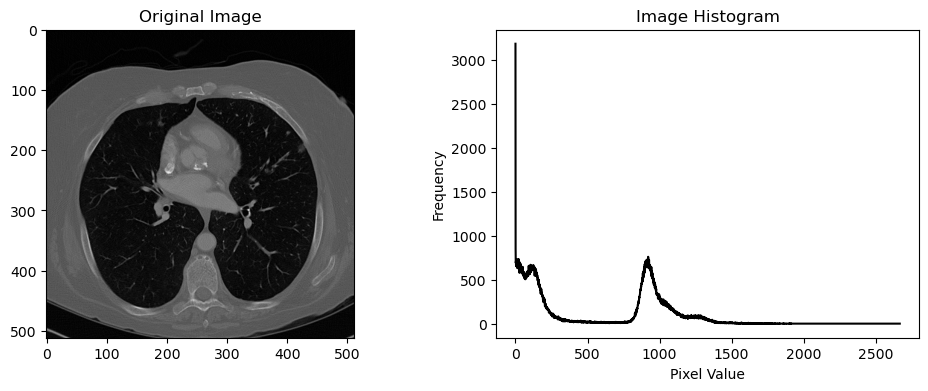

In [4]:
image = orig_dicom.pixel_array
visualise_dicom_and_hist(image)

<h3>Before publication the dataset was preliminary preprocessed by the next stps </h3>
 

<h4> 1. Convertinfd DICOM image into Hounsfield Units </h4>
    <p>$$
HU = \frac{\mu_X - \mu_{\text{water}}}{\mu_{\text{water}} - \mu_{\text{air}}} \times 1000
$$

In [5]:
def converToHU(path):
    dicom = pydicom.dcmread(path) 
    pixel_array = dicom.pixel_array.astype(float)
    rescale_slope = dicom.RescaleSlope
    rescale_intercept = dicom.RescaleIntercept
    hu_array = pixel_array * rescale_slope + rescale_intercept
    return hu_array

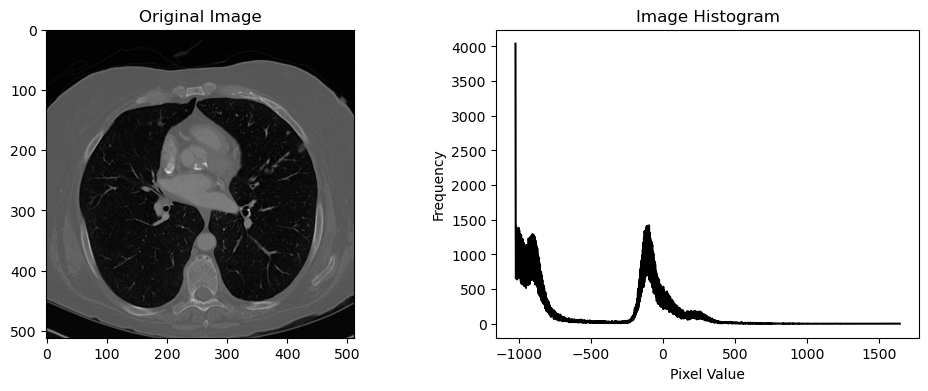

In [6]:
dicom_image = converToHU(path)
visualise_dicom_and_hist(dicom_image)

<h4> 2. Drop areas not related to lung </h4>

To increase the result of model training, thresholding-based segmentation was applied to both the train and test sets to exclude all areas not related to the lungs. The lungs, adjacent tissues, and bones have different densities.

![Sample Image](HU.png)

This factor allows segmentation the lung area via the thresholding method without additional application of neural network to reduce computation complexity.
![image.png](drop_non_lung.png)

In [7]:
def intensity_seg(ct_numpy, min, max):
    clipped = ct_numpy.clip(min, max)
    clipped[clipped != max] = 1
    clipped[clipped == max] = 0
    return measure.find_contours(clipped, 0.95)

def make_dirs(path):
    if os.path.exists(path):
        shutil.rmtree(path)
        os.mkdir(path)
    else:
        os.makedirs(path)

def intensity_seg(ct_numpy, min, max):
    clipped = ct_numpy.clip(min, max)
    clipped[clipped != max] = 1
    clipped[clipped == max] = 0
    return measure.find_contours(clipped, 0.95)

def set_is_closed(contour):
    if contour_distance(contour) < 1:
        return True
    else:
        return False

def find_lungs(contours):
    body_and_lung_contours = []
    vol_contours = []

    for contour in contours:
        hull = ConvexHull(contour)

        if hull.volume > 2000 and set_is_closed(contour):
            body_and_lung_contours.append(contour)
            vol_contours.append(hull.volume)

    if len(body_and_lung_contours) == 2:
        return body_and_lung_contours
    elif len(body_and_lung_contours) > 2:
        vol_contours, body_and_lung_contours = (list(t) for t in
                                                zip(*sorted(zip(vol_contours, body_and_lung_contours))))
        body_and_lung_contours.pop(-1)
        return body_and_lung_contours
def contour_distance(contour):
    dx = contour[0, 1] - contour[-1, 1]
    dy = contour[0, 0] - contour[-1, 0]
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

def compute_area(mask, pixdim):
    mask[mask >= 1] = 1
    lung_pixels = np.sum(mask)
    return lung_pixels * pixdim[0] * pixdim[1]

def create_mask_from_polygon(image, contours):

    lung_mask = np.array(Image.new('L', image.shape, 0))
    for contour in contours:
        x = contour[:, 0]
        y = contour[:, 1]
        polygon_tuple = list(zip(x, y))
        img = Image.new('L', image.shape, 0)
        ImageDraw.Draw(img).polygon(polygon_tuple, outline=0, fill=1)
        mask = np.array(img)
        lung_mask += mask

    lung_mask[lung_mask > 1] = 1  # sanity check to make 100% sure that the mask is binary

    return lung_mask.T  # transpose it to be aligned with the image dims

def return_lung_area(dicom_image):
    contours = intensity_seg(dicom_image, min=-1000, max=-300)
    lungs = find_lungs(contours)
    lung_mask = create_mask_from_polygon(dicom_image, lungs)
    lung_area = lung_mask * dicom_image
    return(lung_area)

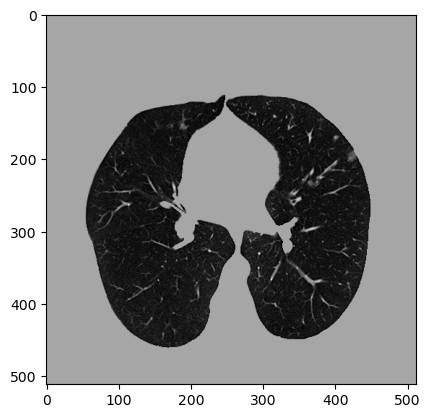

In [8]:
lungs = return_lung_area(dicom_image)
plt.imshow(lungs, cmap="gray")

This image was used as an input of <b>MetaLUNG</b> augmentation method 

<h1><b>MetaLUNG</b>: Meticulous affine-transformation-based lung cancer augmentation method</h1>

<h2>The image has corresponding cancer mask</h2>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


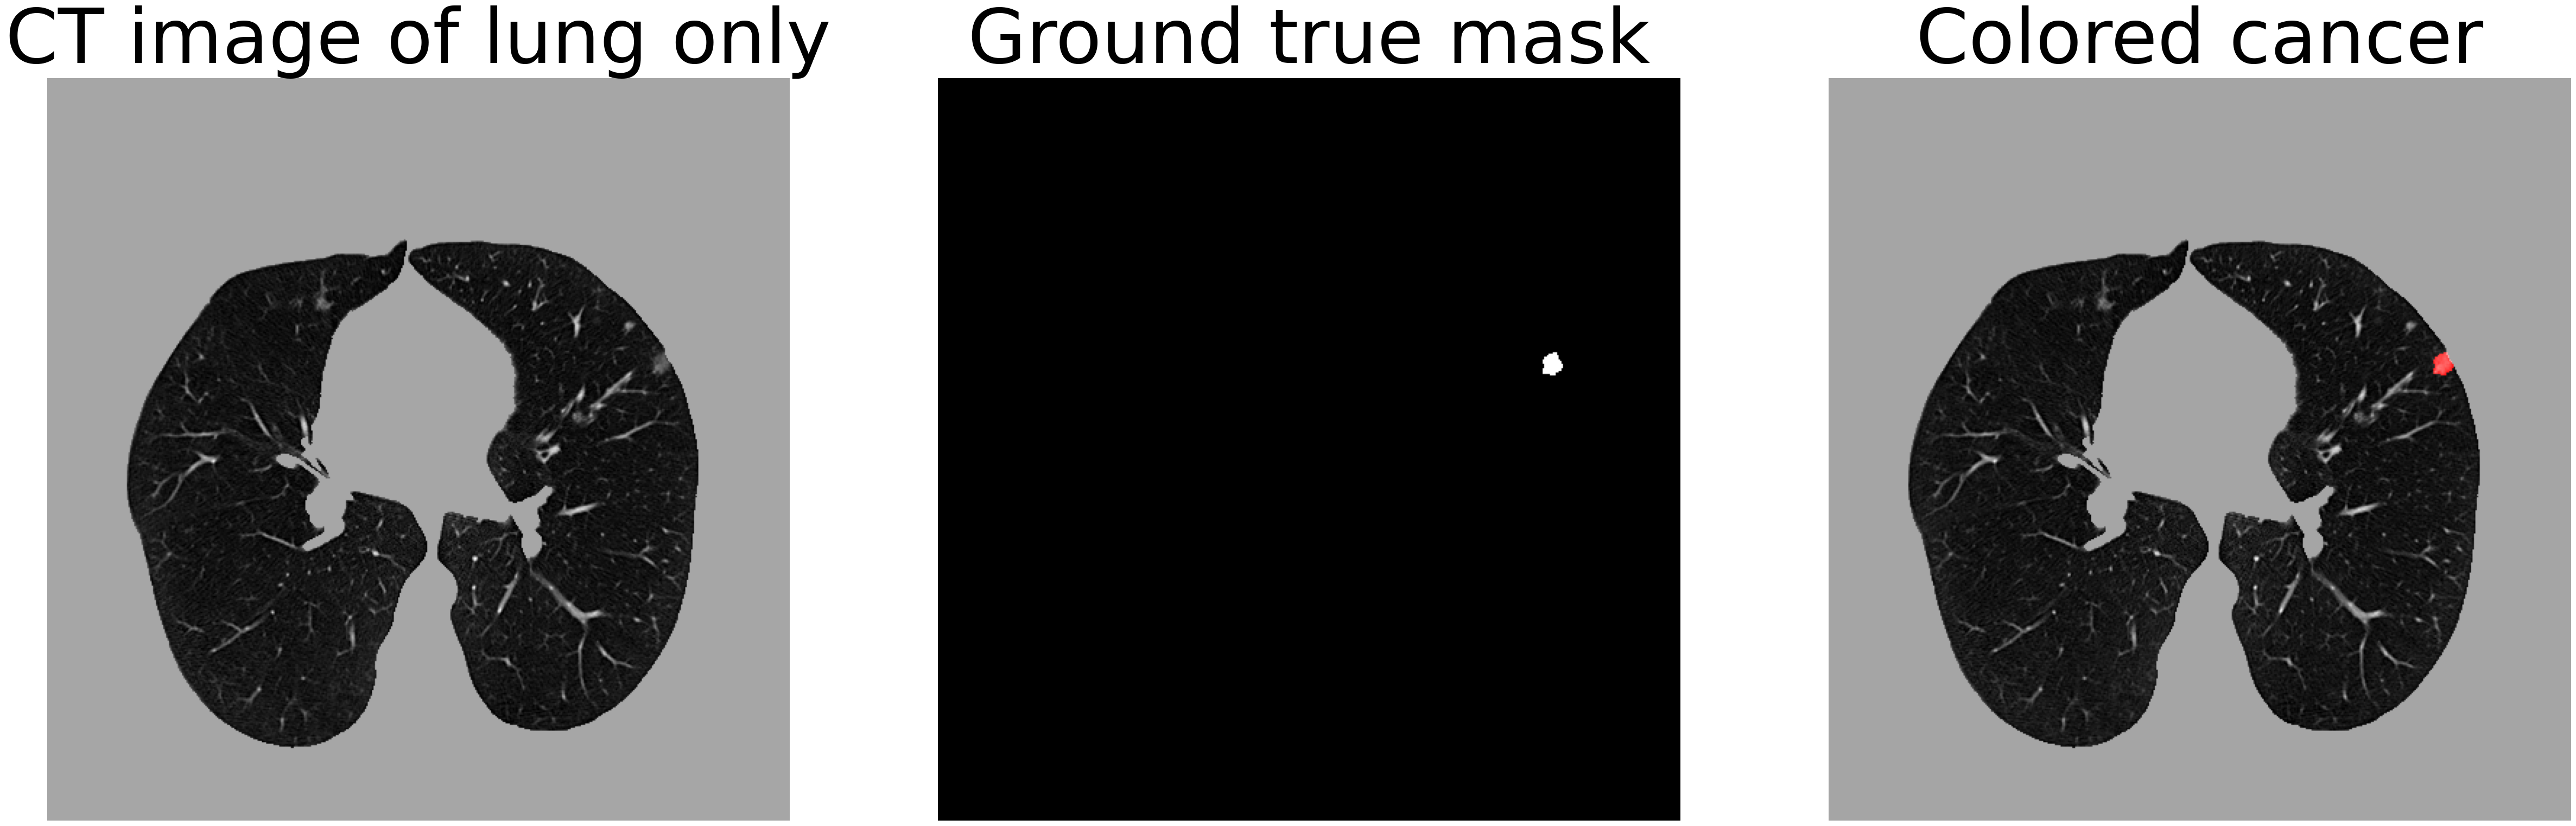

In [9]:
mask_path = "LIDC-IDRI-Example/IM140.png" 
mask = (cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) == 255)**2
img_norm = (lungs-np.min(lungs))/(np.max(lungs)-np.min(lungs))
resulted_image = np.stack((img_norm+mask,img_norm,img_norm),axis=2)
plt.figure(figsize=(60, 60))
plt.subplot(1, 3, 1)
plt.imshow(lungs, cmap='gray')
plt.title('CT image of lung only', fontsize=100)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Ground true mask', fontsize=100)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(resulted_image)
plt.title('Colored cancer', fontsize=100)
plt.axis('off')
plt.show()

<h2><b>MetaLung</b></h2>
<p><b>MetaLung (Meticulous affine-transformation-based lung cancer augmentation method) </b> could be applied for lung cancer classification and segmentation. The method is constructed based on the combination of six affine transformation techniques: 
<ul>
    <li>Mirror the image</li>
    <li>Replacing cancer for free space</li>
    <li>Rotate the image</li>
    <li>Rotate cancer</li>
    <li>Noise to image</li>
    <li>Noise to cancer</li>
</ul>
<p>The method works with DICOM in HU that is original format of computed tomography images. It allows to save the radiological features of original CT image.
<br>The method allows to save the distribution between lung instances by optimal selection of parameters for random values.

In [10]:
def visualize_generation(lung, mask, generated_lung, generated_mask):
    lung_norm = (lung - np.min(lung)) / (np.max(lung) - np.min(lung))
    original_colored_cancer = np.stack((lung_norm + mask, lung_norm, lung_norm), axis=2)
    generated_lung_norm = (generated_lung - np.min(generated_lung)) / (np.max(generated_lung) - np.min(generated_lung))
    generated_colored_cancer = np.stack((generated_lung_norm + generated_mask, generated_lung_norm, generated_lung_norm), axis=2)
    plt.figure(figsize=(24, 12))
    plt.subplot(2, 3, 1)
    plt.imshow(lung, cmap='gray')
    plt.title('Original CT', fontsize=25)
    plt.axis('off')
    plt.subplot(2, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Original Mask', fontsize=25)
    plt.axis('off')
    plt.subplot(2, 3, 3)
    plt.imshow(original_colored_cancer)
    plt.title('Original Colored Cancer', fontsize=25)
    plt.axis('off')
    plt.subplot(2, 3, 4)
    plt.imshow(generated_lung, cmap='gray')
    plt.title('Generated CT', fontsize=25)
    plt.axis('off')
    plt.subplot(2, 3, 5)
    plt.imshow(generated_mask, cmap='gray')
    plt.title('Generated Mask', fontsize=25)
    plt.axis('off')
    plt.subplot(2, 3, 6)
    plt.imshow(generated_colored_cancer)
    plt.title('Generated Colored Cancer', fontsize=25)
    plt.axis('off')
    plt.show()

<h3>Mirroring the image</h3>
All CT images are provided in [512,512] format. The image is mirror-flipped according to the vertical central line with the x-axis 128.

In [11]:
def MirroringTheImage(ct_numpy,cancerMask):
    ct_numpyNew = np.flip(ct_numpy, 1)
    zero = np.flip(cancerMask, 1)
    return ct_numpyNew, zero

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


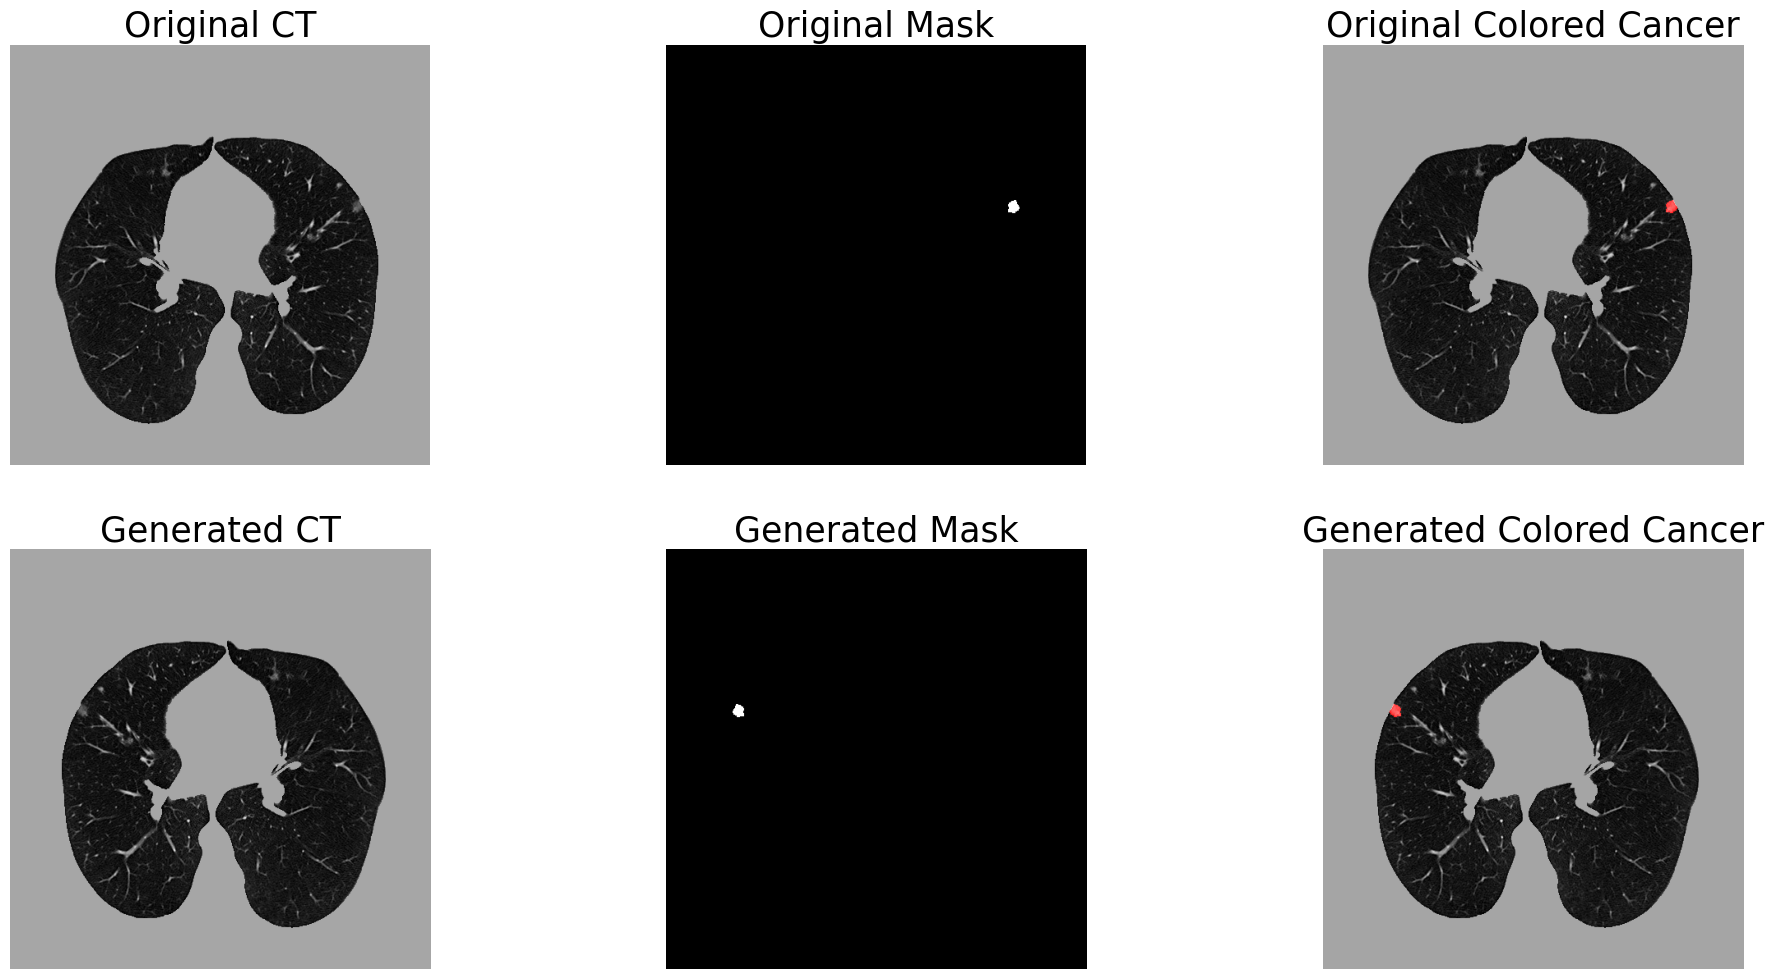

In [12]:
new_ct, new_mask = MirroringTheImage(lungs, mask)
visualize_generation(lungs, mask, new_ct, new_mask)

<h3>Replacing cancer for free space</h3>
Lung and vessels on CT images are preliminarily segmented via a thresholding algorithm. It allows us to get information about the free space from cancer and the vessels area of the lung. The cancer is flipped from the central point to 180 degrees and moved to the free area of the opposite side of the lung if it existed. Only in case there is no free space on the opposite part, the cancer is moved to the same side of the lung. An example of the application of the second method is provided in Figure 2. This method is not applicable to the image in case there is not enough free space to move the cancer because of vessels, calcinates, or other lung structures.

In [13]:
def conv2d_fast(img, krn):
    is0, is1, ks0, ks1 = *img.shape, *krn.shape
    rs0, rs1 = is0 - ks0 + 1, is1 - ks1 + 1
    ix0 = np.arange(ks0)[:, None] + np.arange(rs0)[None, :]
    ix1 = np.arange(ks1)[:, None] + np.arange(rs1)[None, :]
    res = krn[:, None, :, None] * img[(ix0.ravel()[:, None], ix1.ravel()[None, :])].reshape(ks0, rs0, ks1, rs1)
    res = res.transpose(1, 3, 0, 2).reshape(rs0, rs1, -1).sum(axis = -1)
    return res
def create_vessel_mask(lung_mask, ct_numpy, denoise=False):
    vessels = lung_mask * ct_numpy  # isolate lung area
    vessels[vessels == 0] = -1000
    vessels[vessels >= -500] = 1
    vessels[vessels < -500] = 0
    return vessels 
def ReplacingCancerForFreeSpace(ct_numpy,cancerMask):
    contours = intensity_seg(ct_numpy, min=-1000, max=-300)
    lungs = find_lungs(contours)
    lung_mask = create_mask_from_polygon(ct_numpy, lungs)
    vessels = create_vessel_mask(lung_mask, ct_numpy)
    pos = np.where(cancerMask)
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    xmin = min(xmin, xmax)
    xmax = max(xmin, xmax)
    ymin = min(ymin, ymax)
    ymax = max(ymin, ymax)
    b = np.flip(cancerMask[ymin:ymax+1, xmin:xmax+1], 1)
    img = ((lung_mask == 0) + vessels) > 0
    res = conv2d_fast(img, b)
    out = (res == 0)
    if xmin > (img.shape[0]//2):
        out[:,int(img.shape[0]//2):] = 0
    else: 
        out[:,:int(img.shape[0]//2)] = 0
    if np.sum(out) == 0:
        out = (res == 0)
    pos = np.where(out > 0)
    ind = np.argsort(pos[1])[len(pos[1])//2]
    ind = (pos[0][ind], pos[1][ind])
    cancer = cancerMask[ymin:ymax+1, xmin:xmax+1]
    cancer = np.flip(cancer)
    zero = np.zeros([512,512])
    zero[ind[0]:ind[0] +cancer.shape[0],ind[1]:ind[1] + cancer.shape[1]] = cancer
    zero = zero > 0
    newCancer = np.where(zero)
    oldCancer = np.where(cancerMask)
    ct_numpyNew = copy.deepcopy(ct_numpy)
    for i in range(len(newCancer[0])):
        z = ct_numpyNew[newCancer[0][i],newCancer[1][i]]
        ct_numpyNew[newCancer[0][i],newCancer[1][i]] = ct_numpyNew[oldCancer[0][i],oldCancer[1][i]]
        ct_numpyNew[oldCancer[0][i],oldCancer[1][i]] = z
    return ct_numpyNew, zero

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


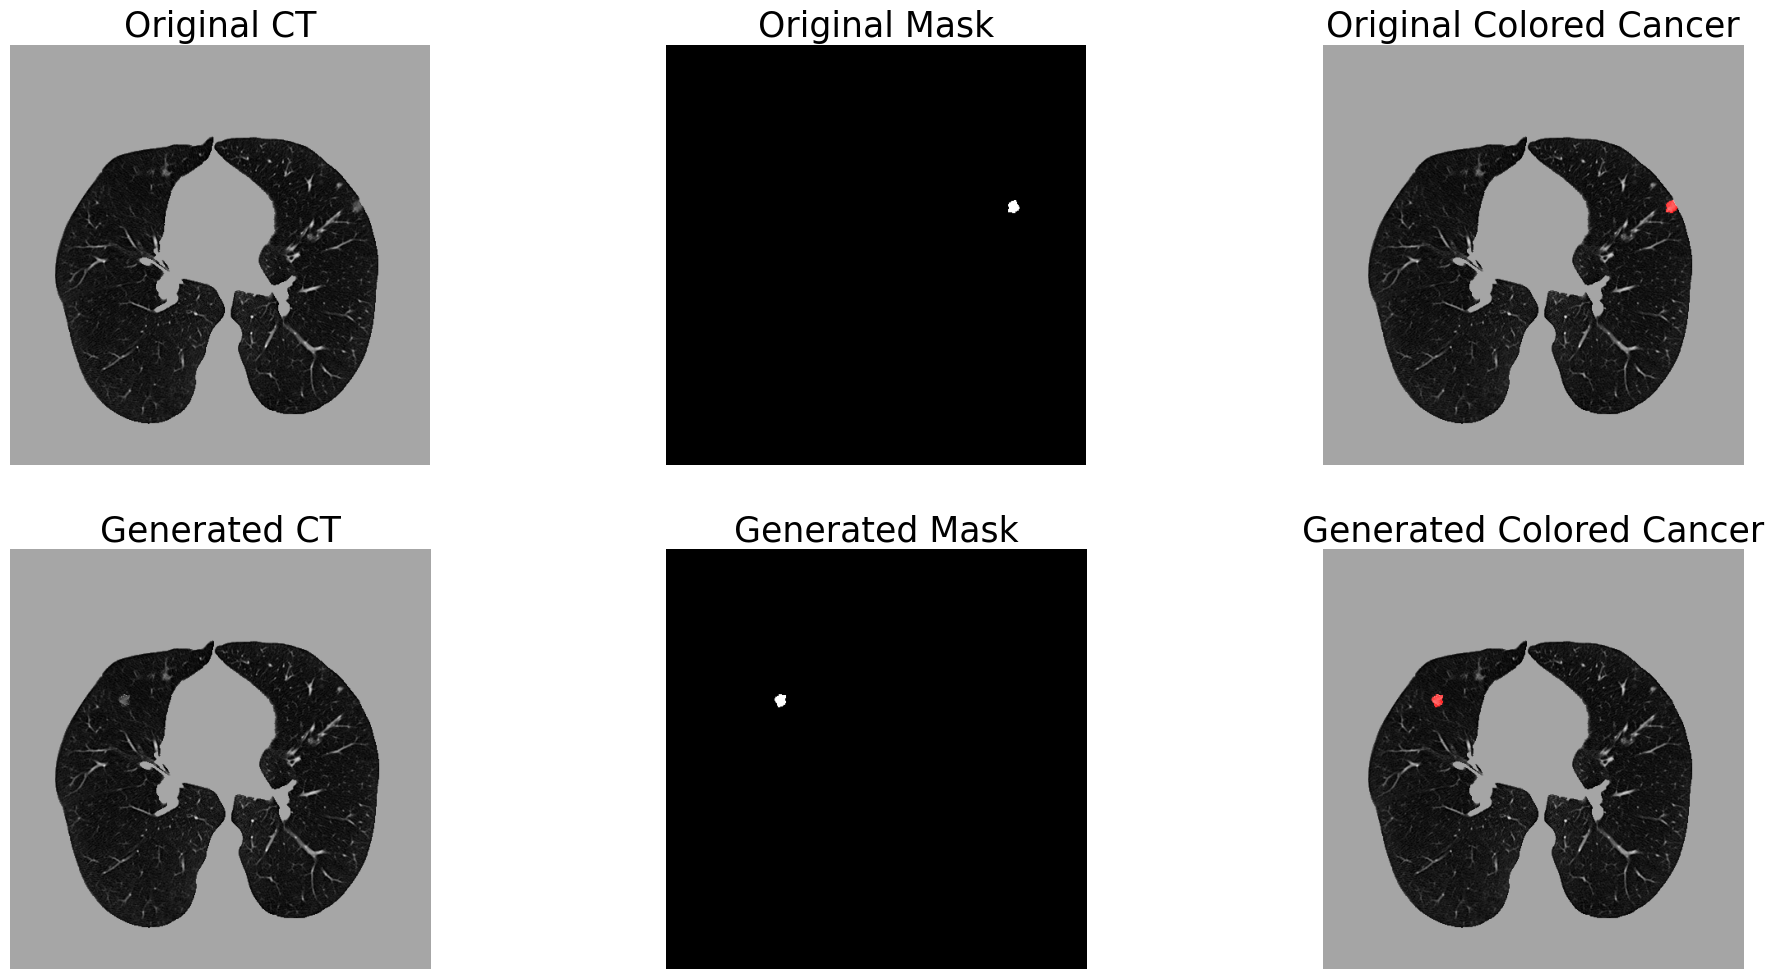

In [14]:
new_ct, new_mask = ReplacingCancerForFreeSpace(lungs, mask)
visualize_generation(lungs, mask, new_ct, new_mask)

<h3>Rotating the image</h3>
The whole image is rotated to random angle from 0 to 90.

In [15]:
def RotatingTheImage(ct_numpy, cancerMask):
    angle_degrees = random.randint(1, 90)
    rotated_mask = rotate(cancerMask, angle_degrees, reshape=False, order=0)
    img = rotate(ct_numpy, angle_degrees, reshape=False, order=0)
    return img, rotated_mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


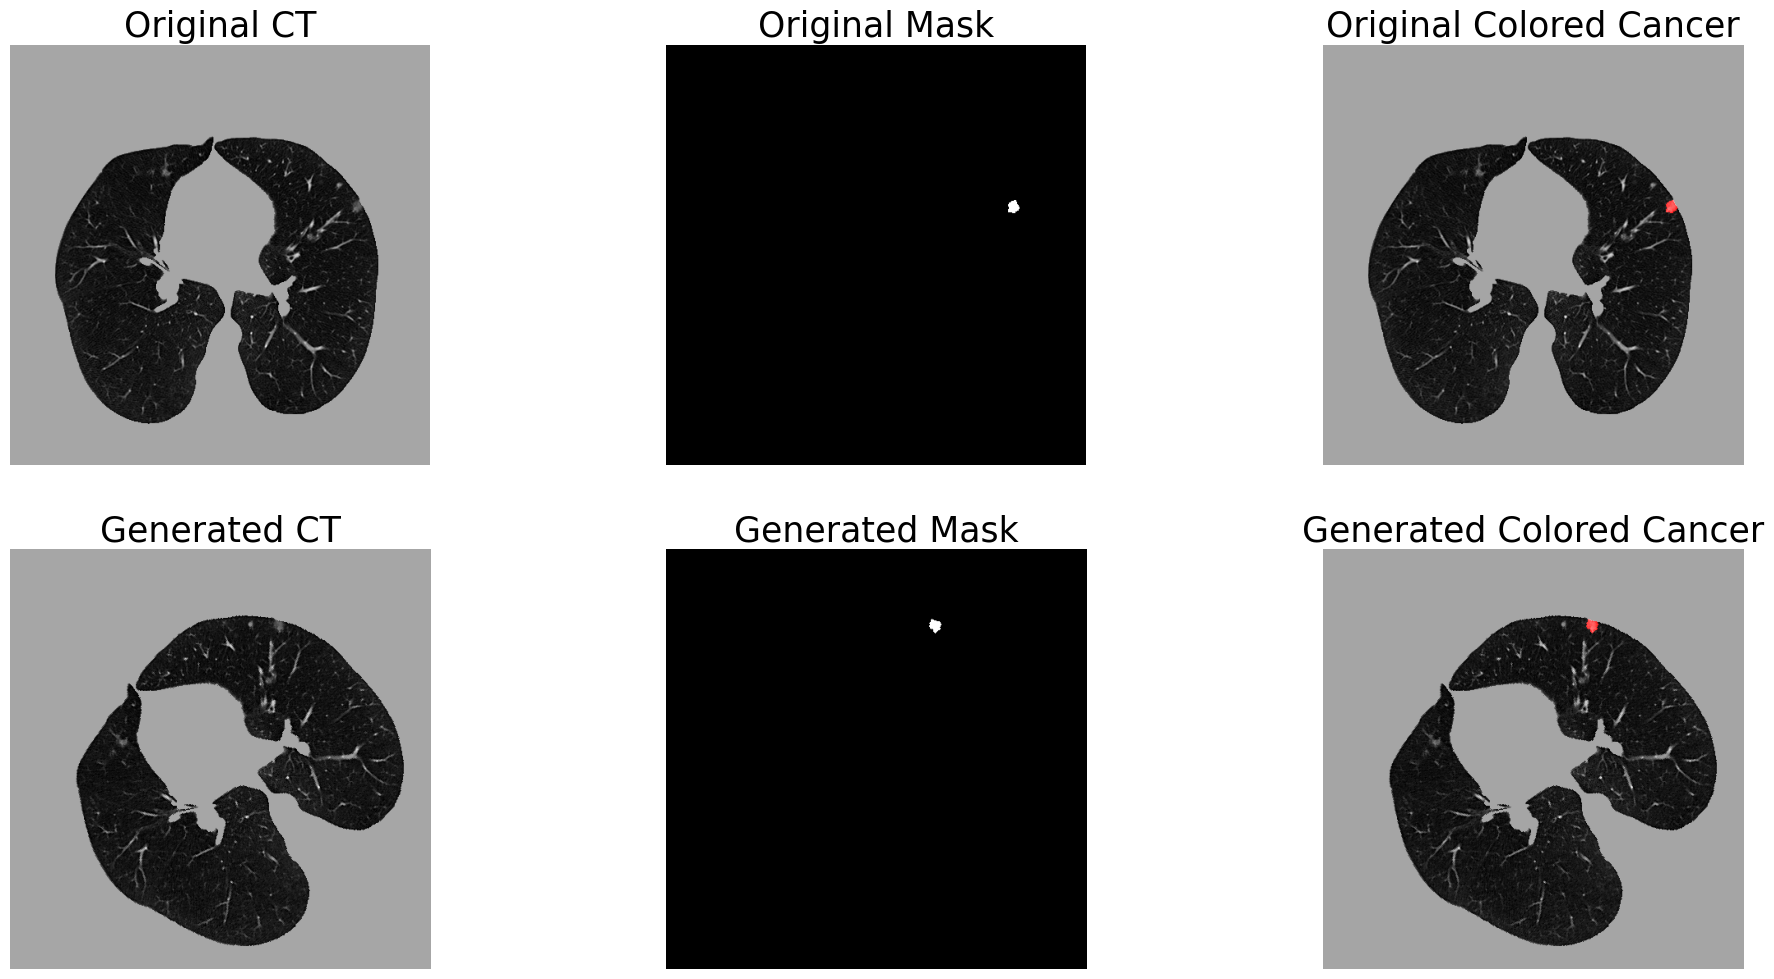

In [16]:
new_ct, new_mask = RotatingTheImage(lungs, mask)
visualize_generation(lungs, mask, new_ct, new_mask)

<h3>Rotating cancer</h3>
The cancer area is rotated to a random angle from 0 to 90. Other parts of the image are not changed and saved as it was

In [17]:
def RotatingCancer(ct_numpy, cancerMask):
    pos = np.where(cancerMask)
    xmin = np.min(pos[0])
    xmax = np.max(pos[0])
    ymin = np.min(pos[1])
    ymax = np.max(pos[1])
    kernel = [xmin, ymin, xmax, ymax]
    angle_degrees = random.randint(1, 90)
    rotated_mask = rotate(cancerMask, angle_degrees, reshape=False, order=0)
    pos = np.where(rotated_mask)
    rxmin = np.min(pos[0])
    rxmax = np.max(pos[0])
    rymin = np.min(pos[1])
    rymax = np.max(pos[1])
    zero = np.zeros([512,512])
    a = rotated_mask[rxmin:rxmax+1, rymin:rymax+1]
    zero[xmin:xmin + a.shape[0],ymin:ymin + a.shape[1]] = a
    img = rotate(ct_numpy, angle_degrees, reshape=False, order=0)
    ct_New = copy.deepcopy(ct_numpy)
    a = img[rxmin:rxmax+1, rymin:rymax+1]
    ct_New[xmin:xmin + a.shape[0],ymin:ymin + a.shape[1]] = a
    return ct_New, zero 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


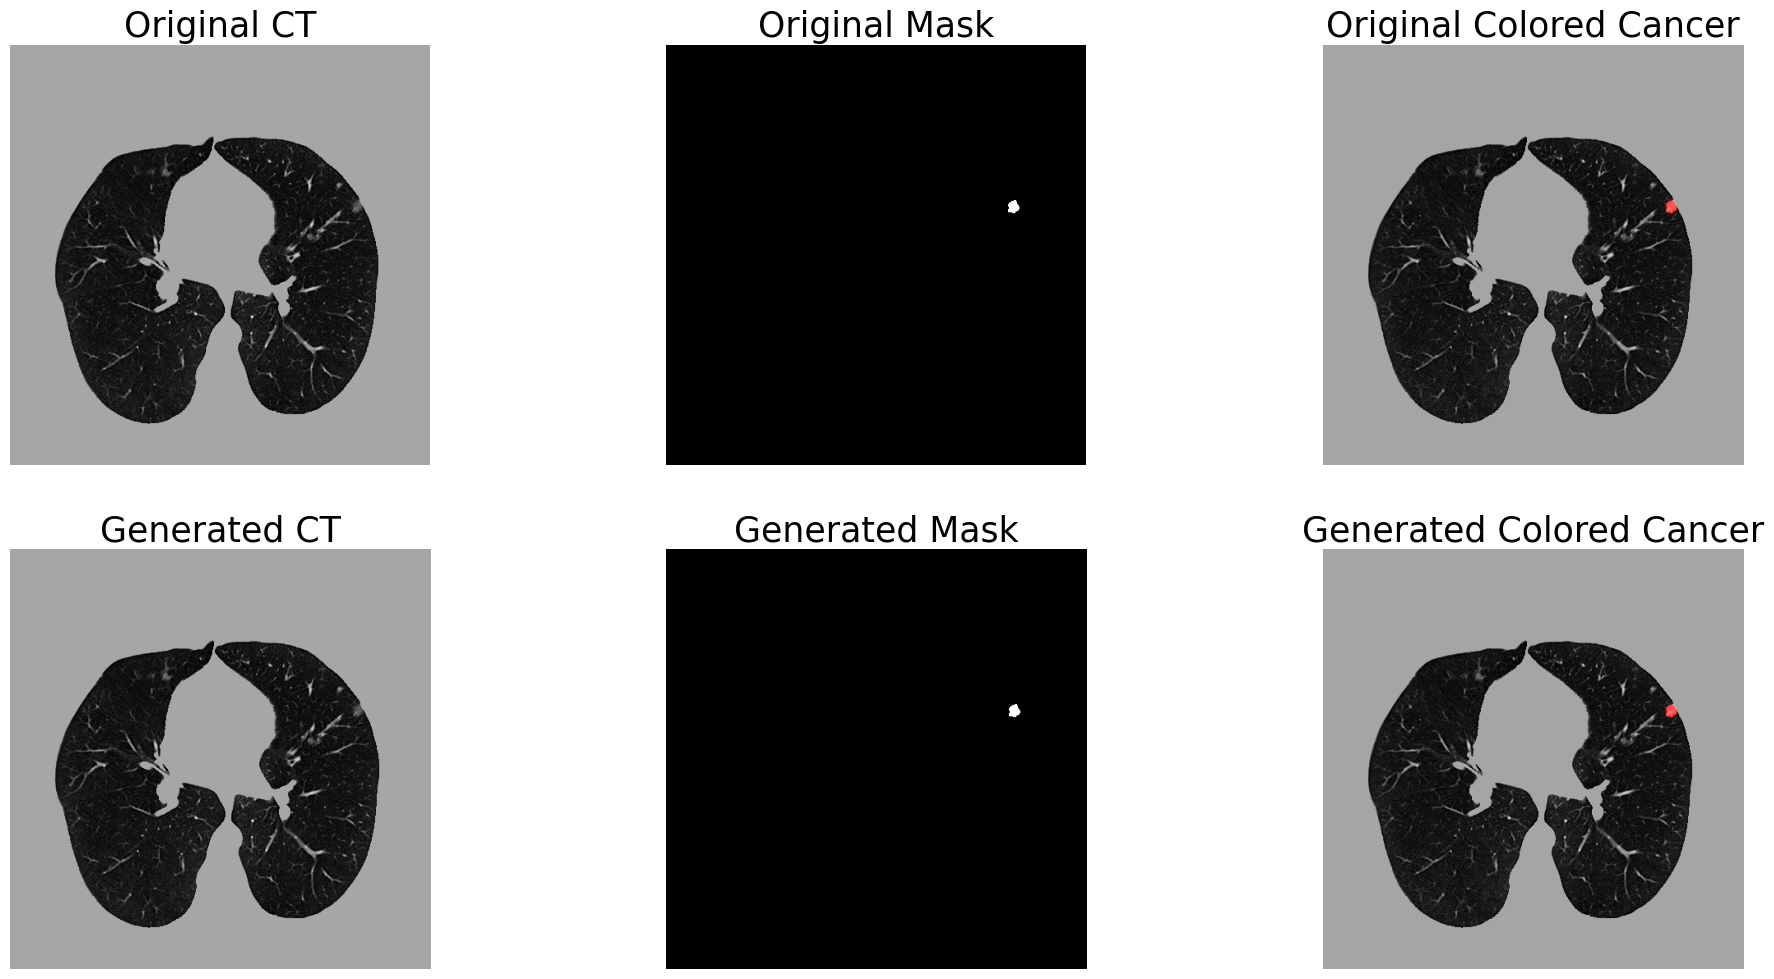

In [18]:
new_ct, new_mask = RotatingCancer(lungs, mask)
visualize_generation(lungs, mask, new_ct, new_mask)

<h3>Adding noise to the image</h3>
The noise with the random value from 0 to 20 is summarized in the whole image. We do not use a big value for noise generation because all instances (lung, bone, cancer, vessels) have fixed value in HU on the CT image. So, we could not apply extreme changes to the image because we want to save this distribution on the image.

In [19]:
def visualize_generation_with_hist_all_img(lung, mask, generated_lung, generated_mask):
    lung_norm = (lung - np.min(lung)) / (np.max(lung) - np.min(lung))
    generated_lung_norm = (generated_lung - np.min(generated_lung)) / (np.max(generated_lung) - np.min(generated_lung))
    original_colored_cancer = np.stack((lung_norm + mask, lung_norm, lung_norm), axis=2)
    generated_colored_cancer = np.stack((generated_lung_norm + generated_mask, generated_lung_norm, generated_lung_norm), axis=2)
    fig, axes = plt.subplots(2, 3, figsize=(24, 12))
    axes[0, 0].imshow(lung, cmap='gray')
    axes[0, 0].set_title('Original CT', fontsize=25)
    axes[0, 0].axis('off')
    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title('Original Mask', fontsize=25)
    axes[0, 1].axis('off')
    axes[0, 2].hist(lung.flatten(), bins='auto', color='blue', alpha=0.7)
    axes[0, 2].set_title('Original CT Histogram', fontsize=25)
    axes[0, 2].set_xlabel('Pixel Value')
    axes[0, 2].set_ylabel('Frequency')
    axes[1, 0].imshow(generated_lung, cmap='gray')
    axes[1, 0].set_title('Generated CT', fontsize=25)
    axes[1, 0].axis('off')
    axes[1, 1].imshow(generated_mask, cmap='gray')
    axes[1, 1].set_title('Generated Mask', fontsize=25)
    axes[1, 1].axis('off')
    axes[1, 2].hist(generated_lung.flatten(), bins='auto', color='blue', alpha=0.7)
    axes[1, 2].set_title('Generated CT Histogram', fontsize=25)
    axes[1, 2].set_xlabel('Pixel Value')
    axes[1, 2].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [20]:
def AddingNoiseToTheImage(ct_numpy,cancerMask):
    array = np.random.randint(low=0, high=20, size=(512,512))
    img = ct_numpy + array
    return img, cancerMask

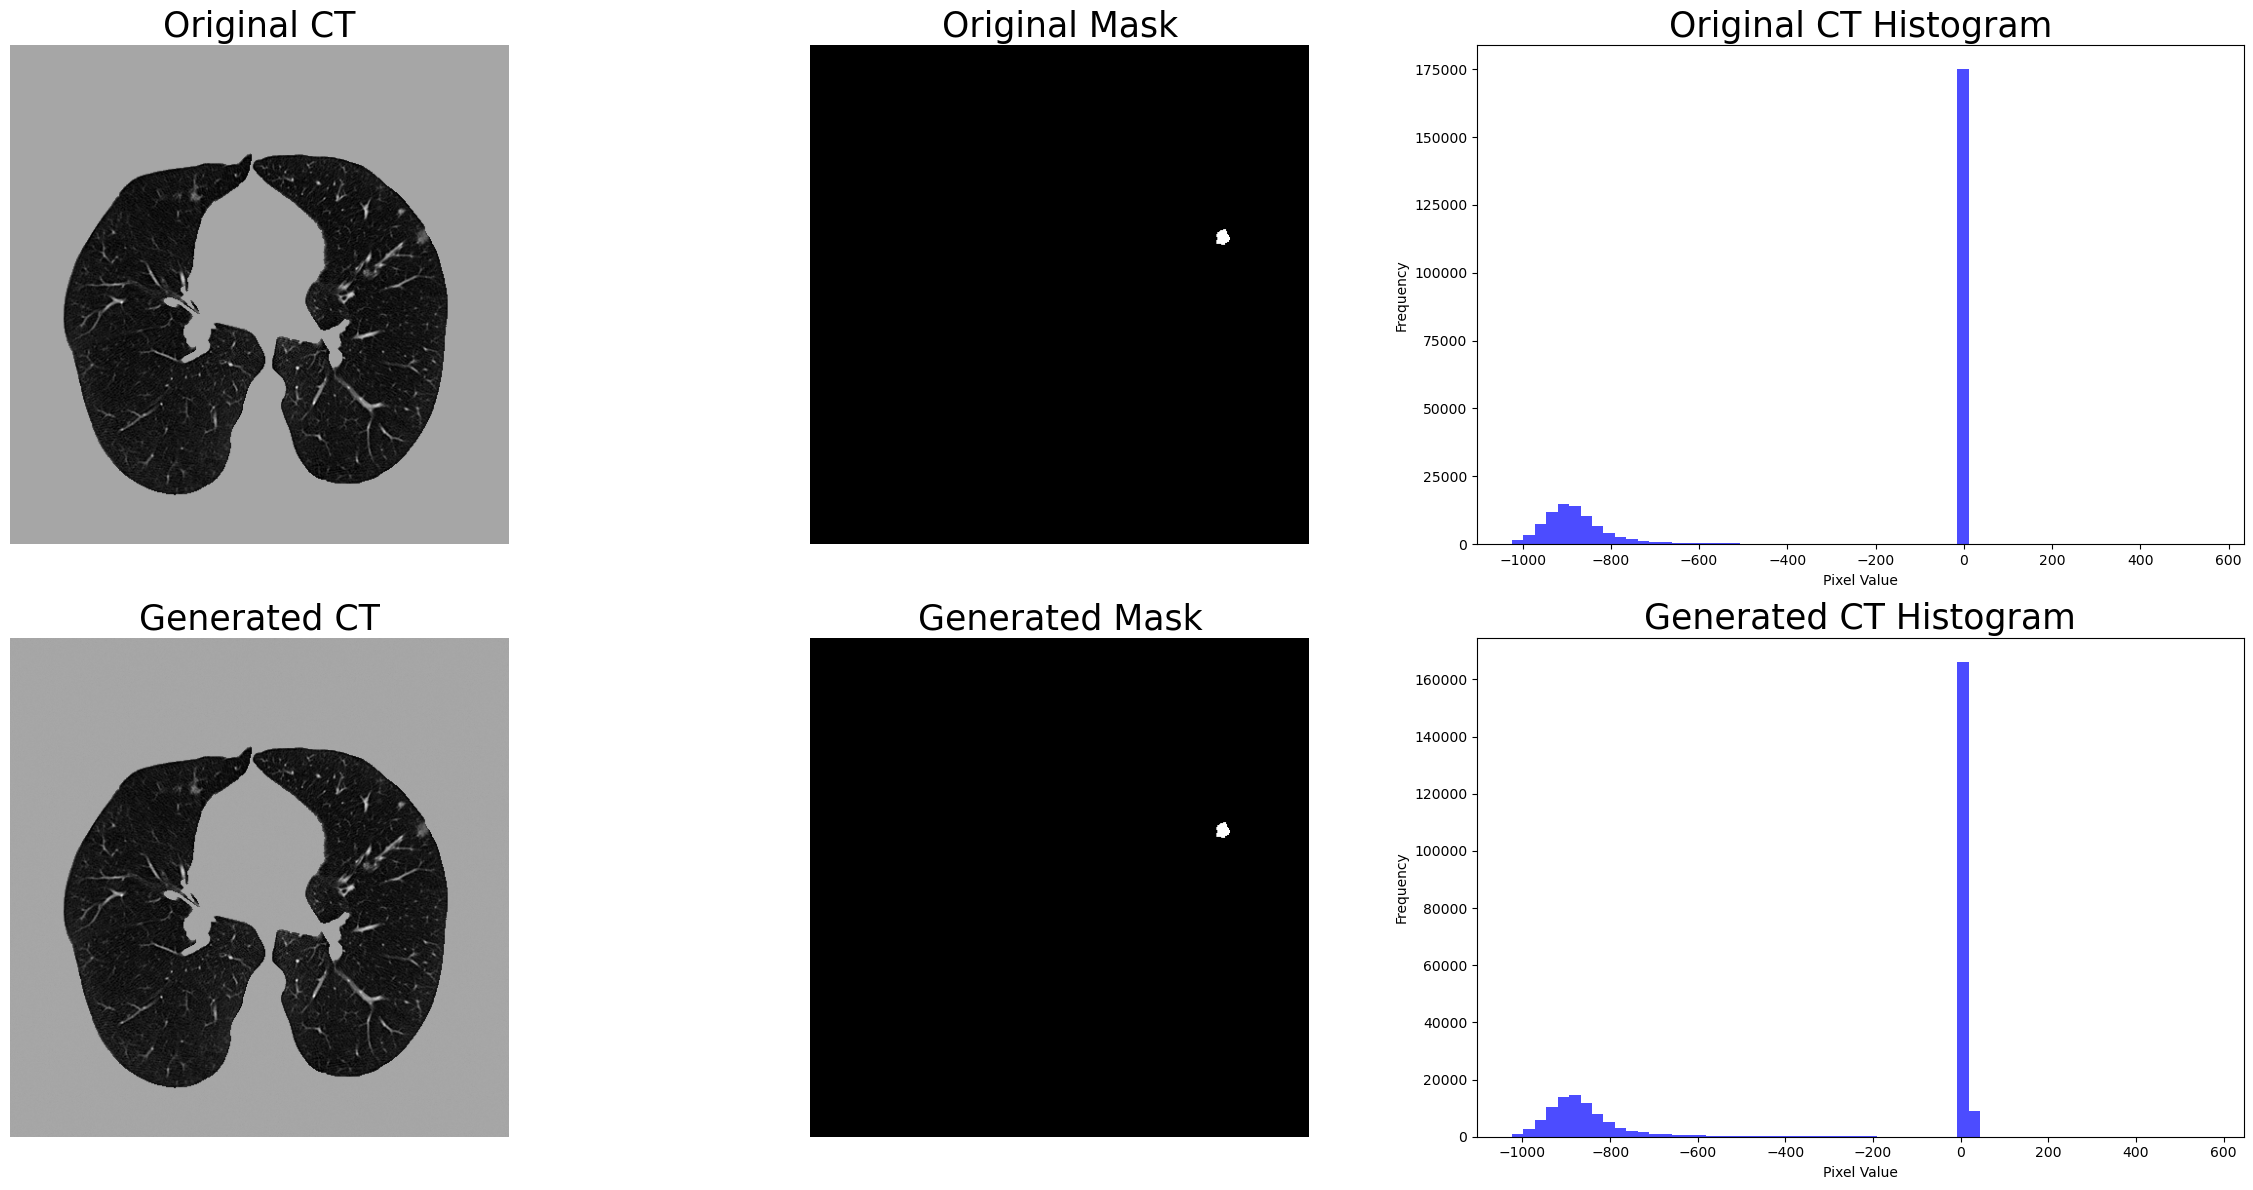

In [21]:
new_ct, new_mask = AddingNoiseToTheImage(lungs, mask)
visualize_generation_with_hist_all_img(lungs, mask, new_ct, new_mask)

<h3>Adding noise to cancer</h3>
The noise with the random value from 0 to 20 is summarized to the cancer area only.

In [22]:
def visualize_cancer_histogram(lung, mask, generated_lung, generated_mask):
    cancer_area_original = lung[mask == 1]
    cancer_area_generated = generated_lung[generated_mask == 1]
    fig, axes = plt.subplots(2, 3, figsize=(24, 12))
    axes[0, 0].imshow(lung, cmap='gray')
    axes[0, 0].set_title('Original CT', fontsize=25)
    axes[0, 0].axis('off')
    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title('Original Mask', fontsize=25)
    axes[0, 1].axis('off')
    axes[0, 2].hist(cancer_area_original, bins='auto', color='blue', alpha=0.7)
    axes[0, 2].set_title('Original Cancer Area Histogram', fontsize=25)
    axes[0, 2].set_xlabel('Pixel Value')
    axes[0, 2].set_ylabel('Frequency')
    axes[1, 0].imshow(generated_lung, cmap='gray')
    axes[1, 0].set_title('Generated CT', fontsize=25)
    axes[1, 0].axis('off')
    axes[1, 1].imshow(generated_mask, cmap='gray')
    axes[1, 1].set_title('Generated Mask', fontsize=25)
    axes[1, 1].axis('off')
    axes[1, 2].hist(cancer_area_generated, bins='auto', color='blue', alpha=0.7)
    axes[1, 2].set_title('Generated Cancer Area Histogram', fontsize=25)
    axes[1, 2].set_xlabel('Pixel Value')
    axes[1, 2].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [23]:
def AddingNoiseToCancer(ct_numpy,cancerMask):
    array = np.random.randint(low=0, high=20, size=(512,512))
    img = ct_numpy + array * cancerMask
    return img, cancerMask

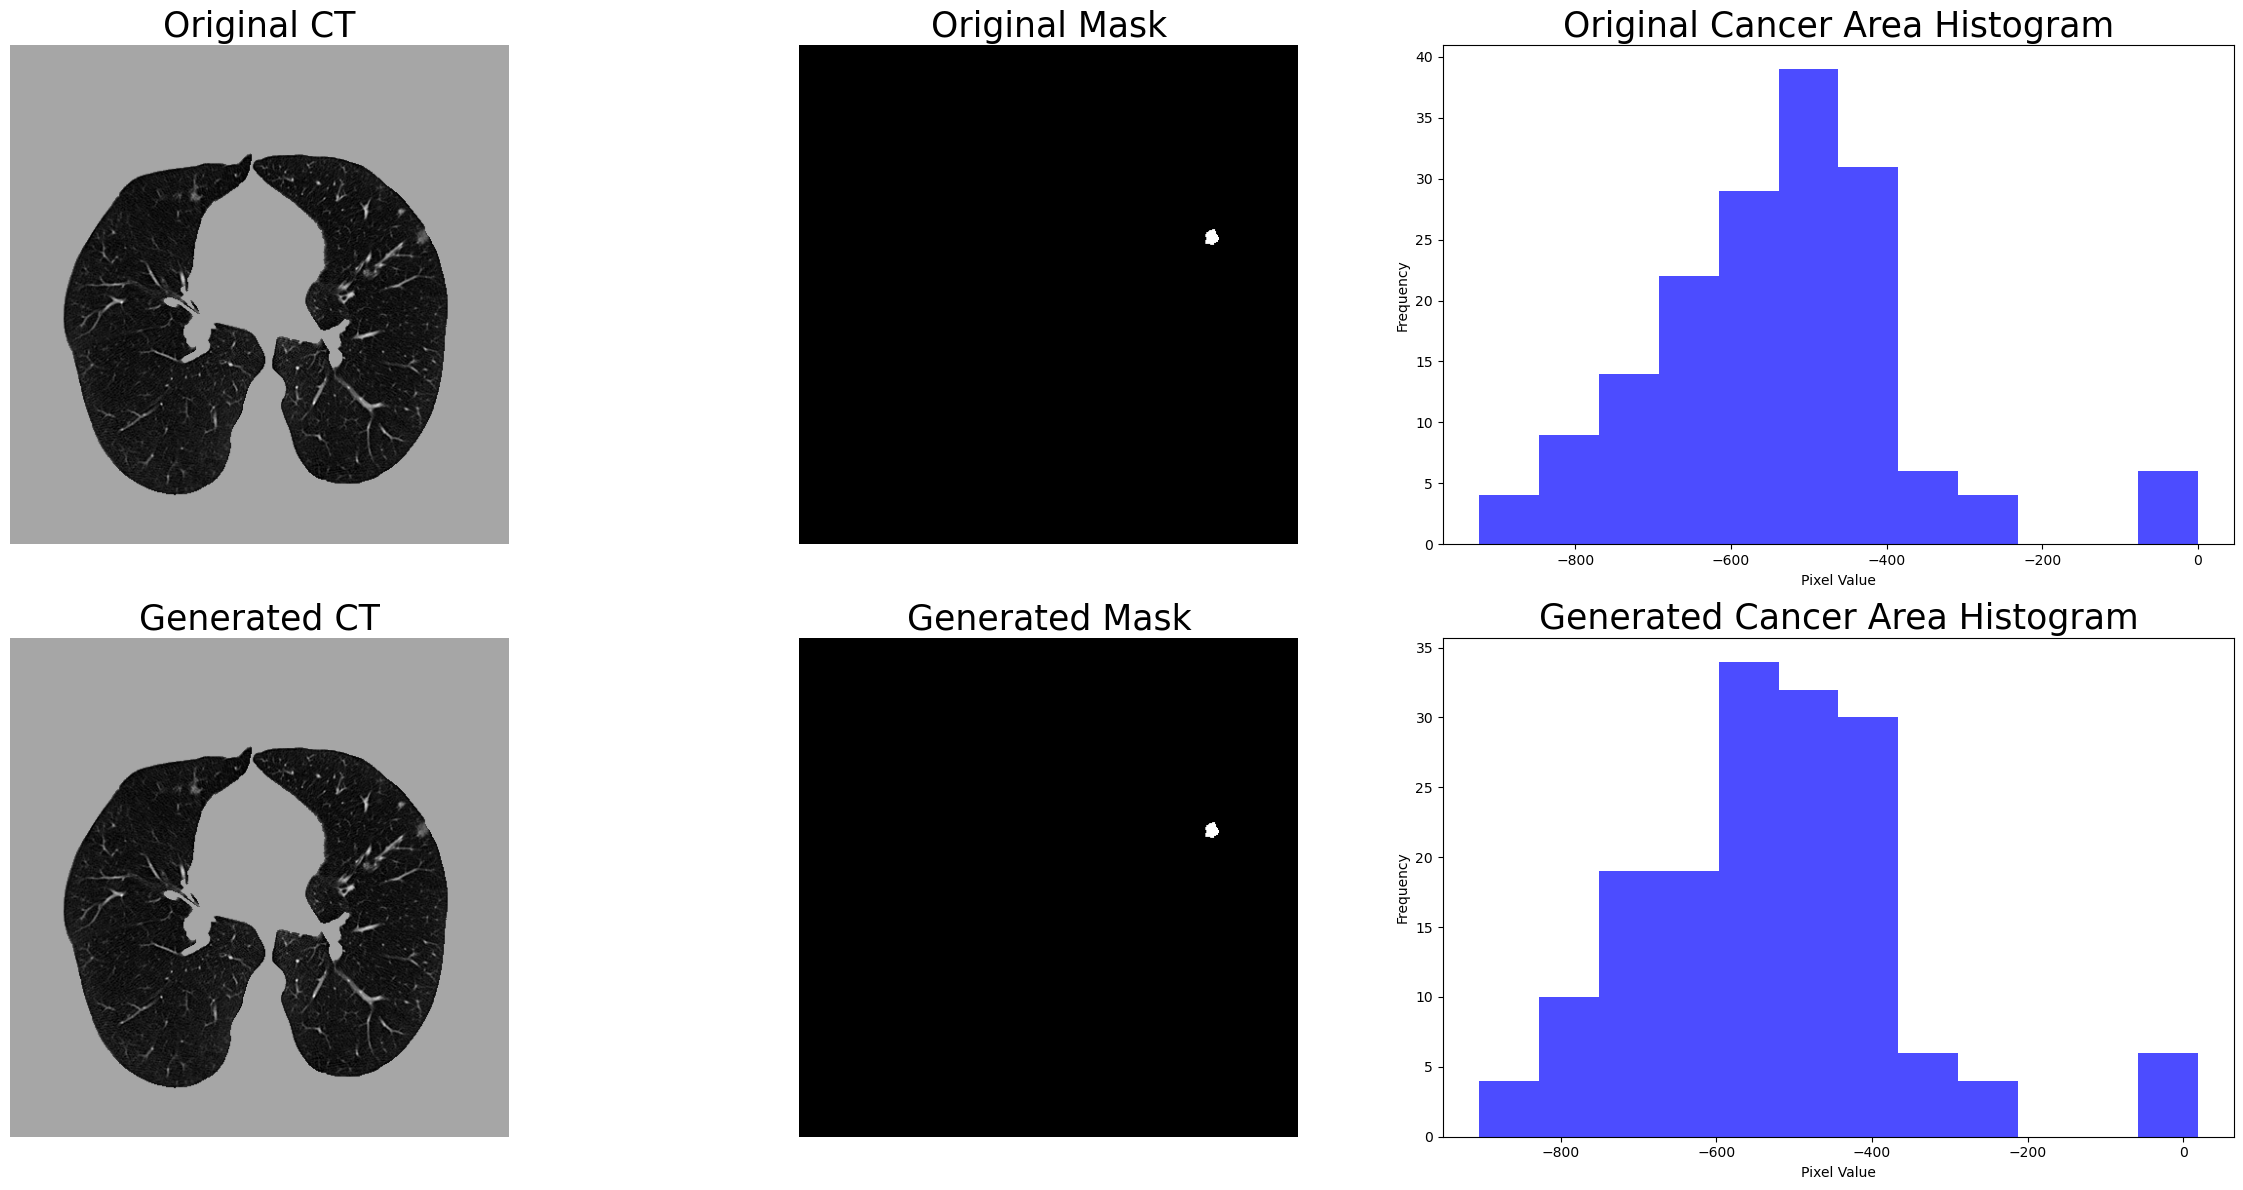

In [24]:
new_ct, new_mask = AddingNoiseToCancer(lungs, mask)
visualize_cancer_histogram(lungs, mask, new_ct, new_mask)

<h1>Evaluation of MetaLUNG</h1>
The same distribution between train and test sets were used for all models.

<h2>EDA for test set</h2>
<ul>
    <li><b>hu_array_old</b> is the CT image converted to HU</li>
    <li><b>hu_array</b> is the segmentated part of lung. We do not evaluate the quality of lung segmentation separately</li>
    <li><b>mask</b> is cancer area</li>
    <li><b>label1</b> is class according to Lung RADS System</li>
</ul>

In [25]:
val_df = pd.read_pickle('lung_cancer_test.pkl')
val_df.head()

label1                                               mask  \
0    LR2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1    LR2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2    LR2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3    LR2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4    LR2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                            hu_array  \
0  [[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...   
1  [[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...   
2  [[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...   
3  [[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...   
4  [[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...   

                                        hu_array_old  
0  [[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,...  
1  [[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,...  
2  [[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,...  
3  [[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,...  
4  [[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,...

In [26]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label1        264 non-null    object
 1   mask          264 non-null    object
 2   hu_array      264 non-null    object
 3   hu_array_old  264 non-null    object
dtypes: object(4)
memory usage: 8.4+ KB


In [27]:
print("Unique types according to Lung RADS: " + str(val_df["label1"].unique()))
visualise_index = [val_df[val_df["label1"] == lr].index[0] for lr in val_df["label1"].unique()]
print("Indices to visualize: " + str(visualise_index))

Unique types according to Lung RADS: ['LR2' 'LR3' 'LR4A' 'LR4B']
Indices to visualize: [0, 35, 62, 68]


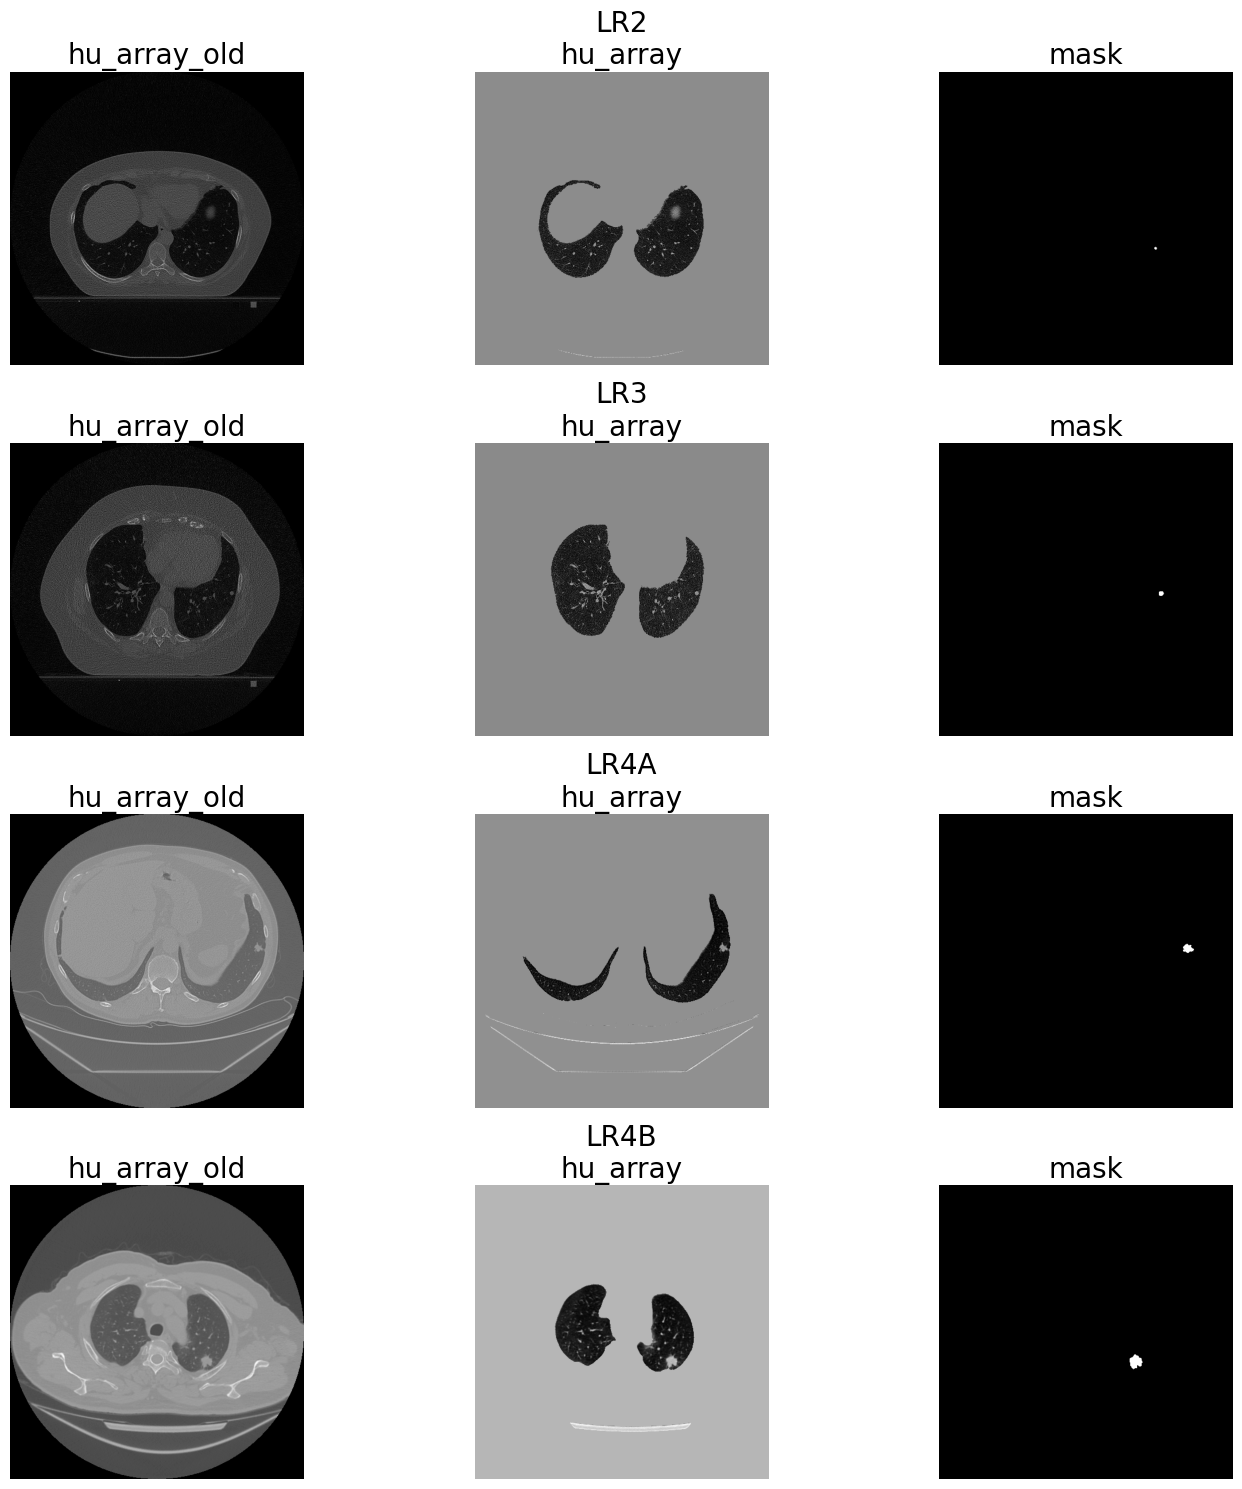

In [28]:
fig, axes = plt.subplots(len(visualise_index), 3, figsize=(15, 15))
for i in range(len(visualise_index)):
    row_label = val_df['label1'][visualise_index[i]]
    axes[i, 0].imshow(val_df['hu_array_old'].values[visualise_index[i]], cmap='gray')
    axes[i, 0].set_title('hu_array_old', fontsize=20)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(val_df['hu_array'].values[visualise_index[i]], cmap='gray')
    axes[i, 1].set_title(f'{row_label}\nhu_array', fontsize=20)
    axes[i, 1].axis('off')
    axes[i, 2].imshow(val_df['mask'].values[visualise_index[i]], cmap='gray')
    axes[i, 2].set_title('mask', fontsize=20)
    axes[i, 2].axis('off')
plt.tight_layout()
plt.show()

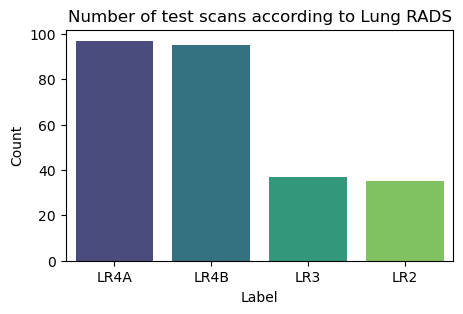

In [29]:
label1_counts = val_df['label1'].value_counts()
plt.figure(figsize=(5, 3))
sns.barplot(x=label1_counts.index, y=label1_counts.values, palette='viridis')
plt.title('Number of test scans according to Lung RADS')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

<h2>Metrics</h2>
<p>We used results of segmentation without data augmentation for all of 3 models as a <b>baseline</b> for each model. We applied 4 metrics to evaluate image segmentation:

<h3>Image segmentation evaluation</h3>

<h4>DICE</h4>
<b>DICE</b> Measures the similarity between two binary masks. It is calculated as twice the intersection divided by the sum of the areas of the two masks. 
$$ \text{Dice Coefficient} = \frac{2 \times \text{Intersection}}{\text{Union} + \epsilon} $$

In [30]:
def calculate_dice_coefficient(mask_true, mask_pred):
    intersection = np.sum(mask_true * mask_pred)
    union = np.sum(mask_true) + np.sum(mask_pred)
    
    dice_coefficient = (2.0 * intersection) / (union + 1e-8)  # Добавляем маленькое значение для избежания деления на ноль
    
    return dice_coefficient

<h4>IoU</h4>
<b>IoU, also known as Jaccard Index </b>, measures the overlap between two masks. It is calculated as the intersection divided by the union of the masks.$$ \text{Intersection over Union (IoU)} = \frac{\text{Intersection} + \epsilon}{\text{Union} + \epsilon} $$

In [31]:
def calculate_iou(mask_true, mask_pred):
    intersection = np.sum(mask_true * mask_pred)
    union = np.sum(mask_true) + np.sum(mask_pred) - intersection
    
    iou = (intersection + 1e-8) / (union + 1e-8)  # Добавляем маленькое значение для избежания деления на ноль
    
    return iou

<h4>Precision</h4>
<b>Precision</b> is the ratio of correctly predicted positive observations to the total predicted positives. It measures the accuracy of the positive predictions.
$$ \text{Precision} = \frac{\text{Intersection} + \epsilon}{\text{Total Predicted Pixels} + \epsilon} $$

In [32]:
def precision_score(groundtruth_mask, pred_mask):
    true_positives = np.sum(pred_mask * groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = (true_positives + 1e-8) / (total_pixel_pred + 1e-8)
    return precision


<h4>Recall</h4>
<b>Recall</b>, also known as sensitivity or true positive rate, is the ratio of correctly predicted positive observations to the total actual positives. It measures the ability of the model to capture all the positive instances.
$$ \text{Recall} = \frac{\text{Intersection} + \epsilon}{\text{Total Actual Positives} + \epsilon} $$

In [33]:
def recall_score(groundtruth_mask, pred_mask):
    true_positives = np.sum(pred_mask * groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = (true_positives + 1e-8) / (total_pixel_truth + 1e-8)
    return recall

<h3>Normalization and CLAHE</h3> 
We normalise each DICOM image from 0 to 1 and used CLAHE
$$\text{img} = \frac{\text{img} - \text{min}(\text{img})}{\text{max}(\text{img}) - \text{min}(\text{img})}$$
$$\text{CLAHE}(I) = \text{Interp}(\text{ClipHistEq}(I))
$$

<h2>Evaluation of <b>MetaLUNG</b> for lung cancer segmentation with CNN</h2>
We used three convolutional-based modes:
    <br>1. U-Net
    <br>2. DeepLab V3
    <br>3. Mask RCNN
<br> for evaluation of <b>MetaLUNG</b> method

<h3>DeepLab V3</h3>
DeepLab V3 is a deep learning model designed by Google for image segmentation. The model utilizes asymmetric convolutions, Atrous (dilated) convolutional blocks, and dilated convolutions with skip architecture to increase the field of view and reduce quality degradation at more distant pixels.


![image.png](DeepLabV3.png)

In [34]:
model = smp.DeepLabV3(
    encoder_name="resnet50",        
    encoder_weights="imagenet",     
    in_channels=1,                  
    classes=1,                     
).cuda()

<h4>The number of trainable parameters</h4>

In [35]:
print(sum(p.numel() for p in model.parameters()))

39627457


In [36]:
def model_evaluation(pretrained_weights, method_name):
    model.load_state_dict(torch.load(pretrained_weights))
    model.eval()
    print('augmentation method name: ' + method_name)
    d = []
    iou = []
    prec = []
    rec = []
    labels = val_df['label1'].unique()
    for j in labels:
        dices = []
        test = val_df.loc[val_df['label1'] == j].reset_index(drop=True)
        for i in range(len(test)):
            mask = test['mask'][i]
            img = test['hu_array'][i]
            img = (img-np.min(img))/(np.max(img)-np.min(img))
            img = exposure.equalize_adapthist(img/np.max(img))
            img = img.astype(np.float64)
            img = transforms.ToTensor()(img)
            img = torch.unsqueeze(img, 0)
            img = img.float()
            img = img.cuda()
            masks = mask.astype(int)
            outputs = model(img)
            outputs = torch.sigmoid(outputs)
            try:
                mask_pred = (outputs.cpu().detach().numpy() >= 0.5) ** 2
            except:
                mask_pred = np.zeros([512,512])
            dices.append(calculate_dice_coefficient(masks, mask_pred))
            d.append(calculate_dice_coefficient(masks, mask_pred))
            iou.append(calculate_iou(masks, mask_pred))
            prec.append(precision_score(masks, mask_pred))
            rec.append(recall_score(masks, mask_pred))
        print("Dice for " + j + " " + str(np.mean(dices))+" " +str(len(dices)))
    print("Average") 
    print("DICE " + str(np.mean(d)))
    print("IoU " + str(np.mean(iou)))
    print("precision " + str(np.mean(prec)))
    print("recall "+str(np.mean(rec)))

<h4>Baseline model</h4>

In [37]:
model_evaluation('weights/deeplabv3 baseline.pth','baseline DeepLabV3 metrics')

augmentation method name: baseline DeepLabV3 metrics
Dice for LR2 0.06454619764796672 35
Dice for LR3 0.3417200106313329 37
Dice for LR4A 0.17736114183536678 97
Dice for LR4B 0.5813429326651246 95
Average
DICE 0.33081199497066505
IoU 0.26909474601054434
precision 0.790670972838993
recall 0.3177733365302212


<h4>Application of MetaLung</h4>

In [38]:
model_evaluation('weights/deeplabv3_all metalung.pth','DeepLabV3 + MetaLUNG')

augmentation method name: DeepLabV3 + MetaLUNG
Dice for LR2 0.045822203832457074 35
Dice for LR3 0.38897099035913296 37
Dice for LR4A 0.39712788804589766 97
Dice for LR4B 0.5755663109118021 95
Average
DICE 0.41362086535794396
IoU 0.34982064801354384
precision 0.8634808411143663
recall 0.3817319958868888


<h3>U-Net</h3>
The U-Net architecture is a convolutional neural network designed for semantic image segmentation tasks. It consists of a contracting block (encoder) for feature extraction and an expansive block (decoder) for spatial information restoration. The architecture incorporates both convolutional and transposed convolutional layers for effective dimensionality reduction and expansion. Added skip connections between corresponding layers of the encoder and decoder facilitate the transmission of detailed information.

![image.png](U-Net.png)

In [39]:
model = smp.Unet(
    encoder_name="vgg11",        
    encoder_weights="imagenet",     
    in_channels=1,                  
    classes=1,                      
).cuda()

<h4>The number of trainable parameters</h4>

In [40]:
print(sum(p.numel() for p in model.parameters()))

18252881


In [41]:
def model_evaluation(pretrained_weights, method_name):
    model.load_state_dict(torch.load(pretrained_weights))
    model.eval()
    print('augmentation method name: ' + method_name)
    d = []
    iou = []
    prec = []
    rec = []
    labels = val_df['label1'].unique()
    for j in labels:
        dices = []
        test = val_df.loc[val_df['label1'] == j].reset_index(drop=True)
        for i in range(len(test)):
            #new_shape = [224,224]
            mask = test['mask'][i]
            img = test['hu_array'][i]
            img = (img-np.min(img))/(np.max(img)-np.min(img))
            img = exposure.equalize_adapthist(img/np.max(img))
            img = img.astype(np.float64)
            img = transforms.ToTensor()(img)
            img = torch.unsqueeze(img, 0)
            img = img.float()
            img = img.cuda()
            masks = mask.astype(int)
            outputs = model(img)
            outputs = torch.sigmoid(outputs)
            try:
                mask_pred = (outputs.cpu().detach().numpy() >= 0.5) ** 2
            except:
                mask_pred = np.zeros([512,512])
            dices.append(calculate_dice_coefficient(masks, mask_pred))
            d.append(calculate_dice_coefficient(masks, mask_pred))
            iou.append(calculate_iou(masks, mask_pred))
            prec.append(precision_score(masks, mask_pred))
            rec.append(recall_score(masks, mask_pred))
        print("Dice for " + j + " " + str(np.mean(dices))+" " +str(len(dices)))
    print("Average") 
    print("DICE " + str(np.mean(d)))
    print("IoU " + str(np.mean(iou)))
    print("precision " + str(np.mean(prec)))
    print("recall "+str(np.mean(rec)))

<h4>Baseline model</h4>

In [42]:
model_evaluation('weights/u-net baseline.pth','Baseline U-Net')

augmentation method name: Baseline U-Net
Dice for LR2 0.19973851536424553 35
Dice for LR3 0.3650203799370373 37
Dice for LR4A 0.19791078606168003 97
Dice for LR4B 0.6127724875295943 95
Average
DICE 0.37086111613149014
IoU 0.3120575950341886
precision 0.817595949951946
recall 0.3590172935386154


<h4>Application of MetaLung</h4>

In [43]:
model_evaluation('weights/u-net_all metalung.pth','U-Net + MetaLUNG')

augmentation method name: U-Net + MetaLUNG
Dice for LR2 0.1346315841657863 35
Dice for LR3 0.36003106397470025 37
Dice for LR4A 0.3655874048638195 97
Dice for LR4B 0.5497952203654822 95
Average
DICE 0.40047643567946106
IoU 0.3418481507648881
precision 0.8676110459950092
recall 0.36841668042556486


<h3>Mask RCNN</h3>
The architecture of the Mask R-CNN model is a logical extension of the Faster R-CNN architecture. Mask R-CNN preserves the two-stage structure of Faster R-CNN, consisting of the Region Proposal Network (RPN) stage and the stage for classification and regression. In addition to object detection, the Mask R-CNN architecture is designed to learn the segmentation and classification of objects in an image

![image.png](Mask-RCNN.png)

In [44]:
torch.set_num_threads(32)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model
model = get_model_instance_segmentation(2).cuda()

/home/a.pak/.conda/envs/u-net/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/a.pak/.conda/envs/u-net/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<h4>The number of trainable parameters</h4>

In [45]:
print(sum(p.numel() for p in model.parameters()))

43922395


In [46]:
def model_evaluation(pretrained_weights, method_name):
    model.load_state_dict(torch.load(pretrained_weights))
    model.eval()
    print('augmentation method name: ' + method_name)
    d = []
    iou = []
    prec = []
    rec = []
    labels = val_df['label1'].unique()
    for j in labels:
        dices = []
        test = val_df.loc[val_df['label1'] == j].reset_index(drop=True)
        for i in range(len(test)):
            #new_shape = [224,224]
            mask = test['mask'][i]
            img = test['hu_array'][i]
            img = (img-np.min(img))/(np.max(img)-np.min(img))
            img = exposure.equalize_adapthist(img/np.max(img))
            img = transforms.ToTensor()(img)
            masks = mask.astype(int)
            out = model([img.to(device, dtype = torch.float)])
            try:
                mask_pred = (out[0]['masks'][0].cpu().detach().numpy()[0] > 0.5) ** 2
            except:
                mask_pred = np.zeros([512,512])
            dices.append(calculate_dice_coefficient(masks, mask_pred))
            d.append(calculate_dice_coefficient(masks, mask_pred))
            iou.append(calculate_iou(masks, mask_pred))
            prec.append(precision_score(masks, mask_pred))
            rec.append(recall_score(masks, mask_pred))
        print("Dice for " + j + " " + str(np.mean(dices))+" " +str(len(dices)))
    print("Average") 
    print("DICE " + str(np.mean(d)))
    print("IoU " + str(np.mean(iou)))
    print("precision " + str(np.mean(prec)))
    print("recall "+str(np.mean(rec)))

<h4>Baseline model</h4>

In [ ]:
model_evaluation('weights/maskrcnn baseline.pth', 'Baseline MASK RCNN')

augmentation method name: Baseline MASK RCNN
Dice for LR2 0.0 35


<h4>Application of MetaLung</h4>

In [ ]:
model_evaluation('weights/maskrcnn_all metalung.pth', 'MASK RCNN + MetaLung')